# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

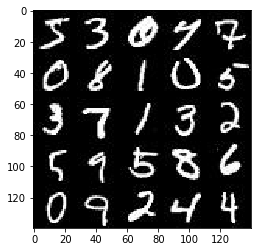

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

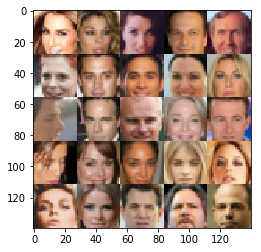

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    z_data = tf.placeholder(tf.float32, shape=[None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(z, alpha=0.01, name='leaky_relu'):
    return tf.maximum(alpha * z, z, name=name)

def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # convblock 1
        # shape = 28x28xC
        
        conv1_1 = tf.layers.conv2d(images, 64, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 14x14x64
        
        conv1_2 = tf.layers.conv2d(conv1_1, 128, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 7x7x128
        # max_pool1_3 = tf.layers.max_pooling2d(conv1_2, pool_size=2, strides=2, padding='valid')
        
        # convblock 2
        conv2_1 = tf.layers.conv2d(conv1_2, 256, kernel_size=3, strides=2, padding='same', activation=leaky_relu)
        # shape = 4x4x256
        # max_pool2_2 = tf.layers.max_pooling2d(conv2_1, pool_size=2, strides=2, padding='valid')
        
        # reshape
        conv2_1_flat = tf.reshape(conv2_1, shape=[-1, 256*4*4])
        conv2_1_flat_drop = tf.layers.dropout(conv2_1_flat, 0.5)
        
        # classifier block
        fc1 = tf.layers.dense(conv2_1_flat_drop, 256, activation=tf.nn.relu)
        fc1_drop = tf.layers.dropout(fc1, 0.5)
        # output
        logits = tf.layers.dense(fc1_drop, 1)
        proba = tf.nn.sigmoid(logits)

    return proba, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        fc1 = tf.layers.dense(z, 7*7*256, activation=leaky_relu)
        fc1_reshape = tf.reshape(fc1, shape=[-1, 7, 7, 256])
        # shape 7x7x256
        
        conv1 = tf.layers.conv2d_transpose(fc1_reshape, 128, kernel_size=3, strides=2, padding="same", activation=leaky_relu)
        # shape 14x14x128
        
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, kernel_size=3, strides=2, padding="same")
        # shape = 28x28x5
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # generator
    g_model = generator(input_z, out_channel_dim)
    
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    # loss values                       
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # g and d trainable vars
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    # optimize g and d
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    
    # input placeholders
    input_real, input_fake, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # loss
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])

    # opimizer
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # random noise for generator
                gen_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # opimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_fake: gen_noise})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_fake: gen_noise})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: gen_noise})
                    train_loss_g = g_loss.eval({input_fake: gen_noise})
                    
                    print("Epoch {}/{} ----".format(epoch_i+1, epochs),
                          "Discrim_loss:{:.4f} ----".format(train_loss_d),
                          "Gen_loss:{:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_fake, data_shape[3], data_image_mode)
                

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ---- Loss - Discriminator:0.8108 ---- Loss - Generator:0.8697
Epoch 1/2 ---- Loss - Discriminator:0.2269 ---- Loss - Generator:2.1107
Epoch 1/2 ---- Loss - Discriminator:0.5410 ---- Loss - Generator:0.9295
Epoch 1/2 ---- Loss - Discriminator:1.1869 ---- Loss - Generator:1.0342
Epoch 1/2 ---- Loss - Discriminator:2.0680 ---- Loss - Generator:2.7813
Epoch 1/2 ---- Loss - Discriminator:1.1212 ---- Loss - Generator:1.2327
Epoch 1/2 ---- Loss - Discriminator:1.1452 ---- Loss - Generator:1.0373
Epoch 1/2 ---- Loss - Discriminator:1.2154 ---- Loss - Generator:0.7571
Epoch 1/2 ---- Loss - Discriminator:1.2296 ---- Loss - Generator:0.4580
Epoch 1/2 ---- Loss - Discriminator:3.5628 ---- Loss - Generator:0.0377


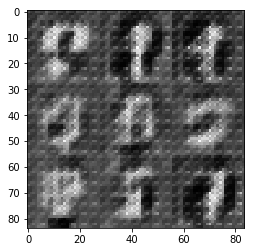

Epoch 1/2 ---- Loss - Discriminator:1.4035 ---- Loss - Generator:0.4318
Epoch 1/2 ---- Loss - Discriminator:1.3664 ---- Loss - Generator:0.4773
Epoch 1/2 ---- Loss - Discriminator:1.1812 ---- Loss - Generator:0.7399
Epoch 1/2 ---- Loss - Discriminator:1.0867 ---- Loss - Generator:0.9868
Epoch 1/2 ---- Loss - Discriminator:1.4168 ---- Loss - Generator:1.6926
Epoch 1/2 ---- Loss - Discriminator:1.6017 ---- Loss - Generator:1.8121
Epoch 1/2 ---- Loss - Discriminator:1.5645 ---- Loss - Generator:0.3453
Epoch 1/2 ---- Loss - Discriminator:1.3172 ---- Loss - Generator:1.1432
Epoch 1/2 ---- Loss - Discriminator:1.1778 ---- Loss - Generator:0.8435
Epoch 1/2 ---- Loss - Discriminator:1.1902 ---- Loss - Generator:0.8092


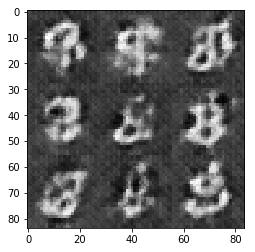

Epoch 1/2 ---- Loss - Discriminator:0.9159 ---- Loss - Generator:1.0706
Epoch 1/2 ---- Loss - Discriminator:1.8262 ---- Loss - Generator:0.2334
Epoch 1/2 ---- Loss - Discriminator:1.3361 ---- Loss - Generator:0.4578
Epoch 1/2 ---- Loss - Discriminator:0.6384 ---- Loss - Generator:2.7827
Epoch 1/2 ---- Loss - Discriminator:1.3361 ---- Loss - Generator:0.4148
Epoch 1/2 ---- Loss - Discriminator:1.3188 ---- Loss - Generator:0.4526
Epoch 1/2 ---- Loss - Discriminator:1.0954 ---- Loss - Generator:0.7136
Epoch 1/2 ---- Loss - Discriminator:1.1489 ---- Loss - Generator:0.6093
Epoch 1/2 ---- Loss - Discriminator:1.1418 ---- Loss - Generator:0.9028
Epoch 1/2 ---- Loss - Discriminator:0.8947 ---- Loss - Generator:0.9330


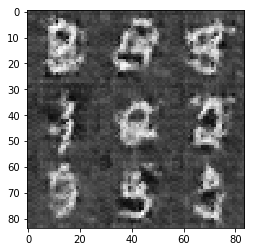

Epoch 1/2 ---- Loss - Discriminator:0.6833 ---- Loss - Generator:1.4418
Epoch 1/2 ---- Loss - Discriminator:0.7604 ---- Loss - Generator:2.6213
Epoch 1/2 ---- Loss - Discriminator:0.6062 ---- Loss - Generator:1.2852
Epoch 1/2 ---- Loss - Discriminator:0.8808 ---- Loss - Generator:1.5856
Epoch 1/2 ---- Loss - Discriminator:0.2166 ---- Loss - Generator:3.2426
Epoch 1/2 ---- Loss - Discriminator:0.9636 ---- Loss - Generator:0.9588
Epoch 1/2 ---- Loss - Discriminator:0.5263 ---- Loss - Generator:1.5321
Epoch 1/2 ---- Loss - Discriminator:0.6537 ---- Loss - Generator:1.1572
Epoch 1/2 ---- Loss - Discriminator:2.4141 ---- Loss - Generator:0.1913
Epoch 1/2 ---- Loss - Discriminator:0.8482 ---- Loss - Generator:0.8087


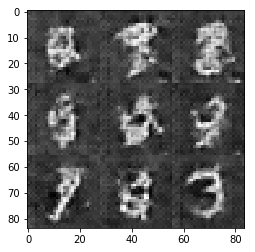

Epoch 1/2 ---- Loss - Discriminator:0.3929 ---- Loss - Generator:2.1246
Epoch 1/2 ---- Loss - Discriminator:1.5603 ---- Loss - Generator:0.2850
Epoch 1/2 ---- Loss - Discriminator:0.6501 ---- Loss - Generator:1.2938
Epoch 1/2 ---- Loss - Discriminator:0.7567 ---- Loss - Generator:1.0255
Epoch 1/2 ---- Loss - Discriminator:0.6076 ---- Loss - Generator:1.2010
Epoch 1/2 ---- Loss - Discriminator:0.7581 ---- Loss - Generator:0.9733
Epoch 1/2 ---- Loss - Discriminator:0.8341 ---- Loss - Generator:3.8832
Epoch 1/2 ---- Loss - Discriminator:0.2456 ---- Loss - Generator:2.3067
Epoch 1/2 ---- Loss - Discriminator:1.8516 ---- Loss - Generator:0.2571
Epoch 1/2 ---- Loss - Discriminator:0.0719 ---- Loss - Generator:4.8676


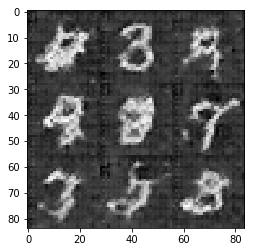

Epoch 1/2 ---- Loss - Discriminator:0.1435 ---- Loss - Generator:5.7268
Epoch 1/2 ---- Loss - Discriminator:0.9206 ---- Loss - Generator:1.3733
Epoch 1/2 ---- Loss - Discriminator:0.5530 ---- Loss - Generator:1.4134
Epoch 1/2 ---- Loss - Discriminator:0.2922 ---- Loss - Generator:2.1130
Epoch 1/2 ---- Loss - Discriminator:0.1153 ---- Loss - Generator:6.0965
Epoch 1/2 ---- Loss - Discriminator:0.1046 ---- Loss - Generator:7.3089
Epoch 1/2 ---- Loss - Discriminator:1.0186 ---- Loss - Generator:0.8767
Epoch 1/2 ---- Loss - Discriminator:0.4537 ---- Loss - Generator:2.2774
Epoch 1/2 ---- Loss - Discriminator:0.3472 ---- Loss - Generator:2.6423
Epoch 1/2 ---- Loss - Discriminator:0.3459 ---- Loss - Generator:1.9415


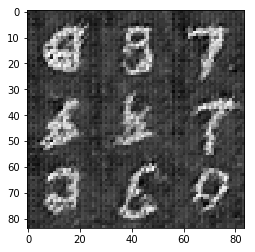

Epoch 1/2 ---- Loss - Discriminator:0.0426 ---- Loss - Generator:4.9227
Epoch 1/2 ---- Loss - Discriminator:0.0338 ---- Loss - Generator:6.2755
Epoch 1/2 ---- Loss - Discriminator:4.0043 ---- Loss - Generator:0.0301
Epoch 1/2 ---- Loss - Discriminator:0.5789 ---- Loss - Generator:1.9285
Epoch 1/2 ---- Loss - Discriminator:0.5137 ---- Loss - Generator:1.4686
Epoch 1/2 ---- Loss - Discriminator:0.2468 ---- Loss - Generator:2.3782
Epoch 1/2 ---- Loss - Discriminator:0.5754 ---- Loss - Generator:1.3579
Epoch 1/2 ---- Loss - Discriminator:1.2171 ---- Loss - Generator:0.6102
Epoch 1/2 ---- Loss - Discriminator:0.3253 ---- Loss - Generator:2.0464
Epoch 1/2 ---- Loss - Discriminator:0.2581 ---- Loss - Generator:2.7167


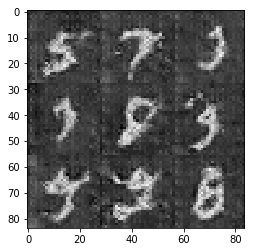

Epoch 1/2 ---- Loss - Discriminator:0.7991 ---- Loss - Generator:0.9831
Epoch 1/2 ---- Loss - Discriminator:0.1194 ---- Loss - Generator:3.7994
Epoch 1/2 ---- Loss - Discriminator:0.1083 ---- Loss - Generator:4.1652
Epoch 1/2 ---- Loss - Discriminator:0.1395 ---- Loss - Generator:5.9920
Epoch 1/2 ---- Loss - Discriminator:0.4846 ---- Loss - Generator:1.9801
Epoch 1/2 ---- Loss - Discriminator:0.7526 ---- Loss - Generator:1.0487
Epoch 1/2 ---- Loss - Discriminator:0.7942 ---- Loss - Generator:1.1041
Epoch 1/2 ---- Loss - Discriminator:0.2528 ---- Loss - Generator:2.9942
Epoch 1/2 ---- Loss - Discriminator:1.1079 ---- Loss - Generator:0.7074
Epoch 1/2 ---- Loss - Discriminator:1.6506 ---- Loss - Generator:0.5752


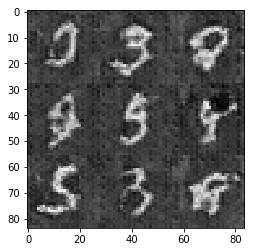

Epoch 1/2 ---- Loss - Discriminator:0.3441 ---- Loss - Generator:2.0311
Epoch 1/2 ---- Loss - Discriminator:1.3158 ---- Loss - Generator:0.8471
Epoch 1/2 ---- Loss - Discriminator:0.3736 ---- Loss - Generator:2.0381
Epoch 1/2 ---- Loss - Discriminator:0.0479 ---- Loss - Generator:5.8193
Epoch 1/2 ---- Loss - Discriminator:0.0992 ---- Loss - Generator:2.9497
Epoch 1/2 ---- Loss - Discriminator:0.0546 ---- Loss - Generator:4.6976
Epoch 1/2 ---- Loss - Discriminator:0.0205 ---- Loss - Generator:7.2366
Epoch 1/2 ---- Loss - Discriminator:0.0576 ---- Loss - Generator:5.6762
Epoch 1/2 ---- Loss - Discriminator:0.3449 ---- Loss - Generator:9.1466
Epoch 1/2 ---- Loss - Discriminator:0.4874 ---- Loss - Generator:1.5910


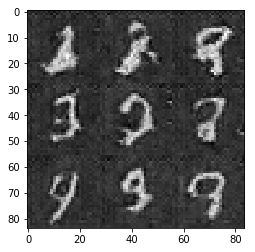

Epoch 1/2 ---- Loss - Discriminator:0.2564 ---- Loss - Generator:2.4671
Epoch 1/2 ---- Loss - Discriminator:0.1921 ---- Loss - Generator:2.5906
Epoch 1/2 ---- Loss - Discriminator:0.0695 ---- Loss - Generator:4.3885
Epoch 2/2 ---- Loss - Discriminator:0.4537 ---- Loss - Generator:2.0315
Epoch 2/2 ---- Loss - Discriminator:0.1811 ---- Loss - Generator:3.0680
Epoch 2/2 ---- Loss - Discriminator:0.3555 ---- Loss - Generator:1.9908
Epoch 2/2 ---- Loss - Discriminator:0.2595 ---- Loss - Generator:2.7276
Epoch 2/2 ---- Loss - Discriminator:0.1528 ---- Loss - Generator:3.6334
Epoch 2/2 ---- Loss - Discriminator:0.1837 ---- Loss - Generator:3.1063
Epoch 2/2 ---- Loss - Discriminator:0.0354 ---- Loss - Generator:5.6172


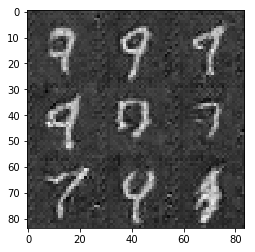

Epoch 2/2 ---- Loss - Discriminator:0.2939 ---- Loss - Generator:2.7363
Epoch 2/2 ---- Loss - Discriminator:0.5887 ---- Loss - Generator:1.7425
Epoch 2/2 ---- Loss - Discriminator:0.8359 ---- Loss - Generator:1.2823
Epoch 2/2 ---- Loss - Discriminator:0.5231 ---- Loss - Generator:1.8732
Epoch 2/2 ---- Loss - Discriminator:1.1906 ---- Loss - Generator:3.3878
Epoch 2/2 ---- Loss - Discriminator:0.6083 ---- Loss - Generator:1.4795
Epoch 2/2 ---- Loss - Discriminator:0.5541 ---- Loss - Generator:1.4100
Epoch 2/2 ---- Loss - Discriminator:0.3184 ---- Loss - Generator:2.3071
Epoch 2/2 ---- Loss - Discriminator:0.3659 ---- Loss - Generator:2.4083
Epoch 2/2 ---- Loss - Discriminator:0.0728 ---- Loss - Generator:4.4325


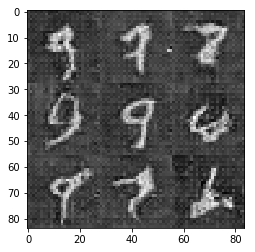

Epoch 2/2 ---- Loss - Discriminator:0.0691 ---- Loss - Generator:4.4440
Epoch 2/2 ---- Loss - Discriminator:0.2897 ---- Loss - Generator:3.1583
Epoch 2/2 ---- Loss - Discriminator:0.2070 ---- Loss - Generator:3.2793
Epoch 2/2 ---- Loss - Discriminator:0.5217 ---- Loss - Generator:1.9738
Epoch 2/2 ---- Loss - Discriminator:0.1620 ---- Loss - Generator:6.7522
Epoch 2/2 ---- Loss - Discriminator:0.0533 ---- Loss - Generator:5.1111
Epoch 2/2 ---- Loss - Discriminator:0.1674 ---- Loss - Generator:6.0365
Epoch 2/2 ---- Loss - Discriminator:0.0832 ---- Loss - Generator:3.9727
Epoch 2/2 ---- Loss - Discriminator:0.0189 ---- Loss - Generator:6.6070
Epoch 2/2 ---- Loss - Discriminator:0.0473 ---- Loss - Generator:4.9534


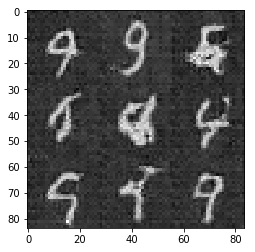

Epoch 2/2 ---- Loss - Discriminator:0.4122 ---- Loss - Generator:1.7638
Epoch 2/2 ---- Loss - Discriminator:0.2877 ---- Loss - Generator:3.4085
Epoch 2/2 ---- Loss - Discriminator:0.1100 ---- Loss - Generator:4.5260
Epoch 2/2 ---- Loss - Discriminator:0.0525 ---- Loss - Generator:5.6449
Epoch 2/2 ---- Loss - Discriminator:1.1320 ---- Loss - Generator:7.0463
Epoch 2/2 ---- Loss - Discriminator:0.8913 ---- Loss - Generator:1.0018
Epoch 2/2 ---- Loss - Discriminator:0.8426 ---- Loss - Generator:1.1310
Epoch 2/2 ---- Loss - Discriminator:0.5350 ---- Loss - Generator:2.3774
Epoch 2/2 ---- Loss - Discriminator:0.4077 ---- Loss - Generator:1.8522
Epoch 2/2 ---- Loss - Discriminator:0.8451 ---- Loss - Generator:3.5588


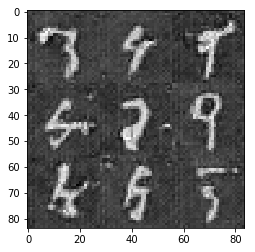

Epoch 2/2 ---- Loss - Discriminator:0.5230 ---- Loss - Generator:1.5969
Epoch 2/2 ---- Loss - Discriminator:0.3829 ---- Loss - Generator:2.1756
Epoch 2/2 ---- Loss - Discriminator:0.4859 ---- Loss - Generator:1.5931
Epoch 2/2 ---- Loss - Discriminator:0.3990 ---- Loss - Generator:2.4589
Epoch 2/2 ---- Loss - Discriminator:0.7205 ---- Loss - Generator:1.2746
Epoch 2/2 ---- Loss - Discriminator:0.3571 ---- Loss - Generator:2.2130
Epoch 2/2 ---- Loss - Discriminator:0.3849 ---- Loss - Generator:2.0336
Epoch 2/2 ---- Loss - Discriminator:0.1290 ---- Loss - Generator:4.5242
Epoch 2/2 ---- Loss - Discriminator:0.8310 ---- Loss - Generator:5.9604
Epoch 2/2 ---- Loss - Discriminator:0.4350 ---- Loss - Generator:2.0003


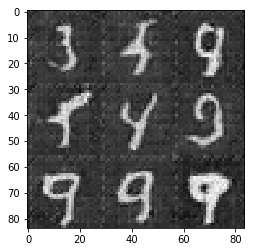

Epoch 2/2 ---- Loss - Discriminator:0.3022 ---- Loss - Generator:2.5547
Epoch 2/2 ---- Loss - Discriminator:0.1125 ---- Loss - Generator:3.7362
Epoch 2/2 ---- Loss - Discriminator:0.4542 ---- Loss - Generator:2.0227
Epoch 2/2 ---- Loss - Discriminator:0.1538 ---- Loss - Generator:3.6049
Epoch 2/2 ---- Loss - Discriminator:0.3073 ---- Loss - Generator:2.2280
Epoch 2/2 ---- Loss - Discriminator:0.2675 ---- Loss - Generator:2.9392
Epoch 2/2 ---- Loss - Discriminator:0.3845 ---- Loss - Generator:2.4080
Epoch 2/2 ---- Loss - Discriminator:0.1956 ---- Loss - Generator:2.9702
Epoch 2/2 ---- Loss - Discriminator:0.4158 ---- Loss - Generator:2.1947
Epoch 2/2 ---- Loss - Discriminator:0.2313 ---- Loss - Generator:3.0290


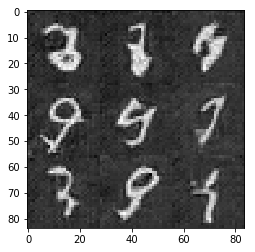

Epoch 2/2 ---- Loss - Discriminator:0.1859 ---- Loss - Generator:3.6216
Epoch 2/2 ---- Loss - Discriminator:0.4346 ---- Loss - Generator:1.9108
Epoch 2/2 ---- Loss - Discriminator:0.2459 ---- Loss - Generator:2.4175
Epoch 2/2 ---- Loss - Discriminator:0.1931 ---- Loss - Generator:3.7702
Epoch 2/2 ---- Loss - Discriminator:0.1494 ---- Loss - Generator:3.0951
Epoch 2/2 ---- Loss - Discriminator:0.1660 ---- Loss - Generator:4.9522
Epoch 2/2 ---- Loss - Discriminator:0.1230 ---- Loss - Generator:3.6044
Epoch 2/2 ---- Loss - Discriminator:0.0547 ---- Loss - Generator:4.0105
Epoch 2/2 ---- Loss - Discriminator:0.0276 ---- Loss - Generator:4.1155
Epoch 2/2 ---- Loss - Discriminator:0.0750 ---- Loss - Generator:9.8750


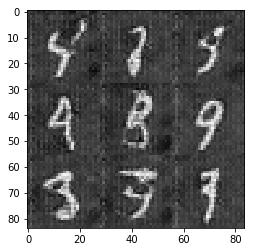

Epoch 2/2 ---- Loss - Discriminator:0.5961 ---- Loss - Generator:2.1215
Epoch 2/2 ---- Loss - Discriminator:0.1259 ---- Loss - Generator:3.9213
Epoch 2/2 ---- Loss - Discriminator:0.0046 ---- Loss - Generator:6.6789
Epoch 2/2 ---- Loss - Discriminator:1.1780 ---- Loss - Generator:1.0827
Epoch 2/2 ---- Loss - Discriminator:0.3054 ---- Loss - Generator:2.3457
Epoch 2/2 ---- Loss - Discriminator:0.0444 ---- Loss - Generator:5.3482
Epoch 2/2 ---- Loss - Discriminator:0.1795 ---- Loss - Generator:3.2874
Epoch 2/2 ---- Loss - Discriminator:0.1610 ---- Loss - Generator:3.6096
Epoch 2/2 ---- Loss - Discriminator:0.0180 ---- Loss - Generator:6.0583
Epoch 2/2 ---- Loss - Discriminator:0.1794 ---- Loss - Generator:2.9072


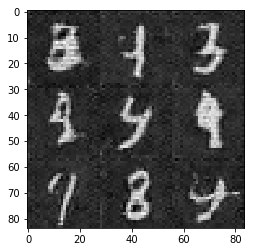

Epoch 2/2 ---- Loss - Discriminator:1.0109 ---- Loss - Generator:5.3386
Epoch 2/2 ---- Loss - Discriminator:0.0855 ---- Loss - Generator:4.0570
Epoch 2/2 ---- Loss - Discriminator:0.1650 ---- Loss - Generator:3.9669
Epoch 2/2 ---- Loss - Discriminator:0.6196 ---- Loss - Generator:1.6548
Epoch 2/2 ---- Loss - Discriminator:0.1017 ---- Loss - Generator:3.7026
Epoch 2/2 ---- Loss - Discriminator:0.0561 ---- Loss - Generator:6.5344
Epoch 2/2 ---- Loss - Discriminator:0.7393 ---- Loss - Generator:1.2839
Epoch 2/2 ---- Loss - Discriminator:0.5072 ---- Loss - Generator:1.6401
Epoch 2/2 ---- Loss - Discriminator:0.1921 ---- Loss - Generator:2.6993
Epoch 2/2 ---- Loss - Discriminator:0.1647 ---- Loss - Generator:3.4954


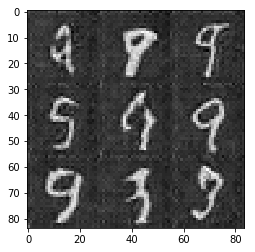

Epoch 2/2 ---- Loss - Discriminator:0.1908 ---- Loss - Generator:3.1432
Epoch 2/2 ---- Loss - Discriminator:2.3052 ---- Loss - Generator:0.3828
Epoch 2/2 ---- Loss - Discriminator:0.4439 ---- Loss - Generator:1.9160
Epoch 2/2 ---- Loss - Discriminator:0.1036 ---- Loss - Generator:3.8048
Epoch 2/2 ---- Loss - Discriminator:0.0809 ---- Loss - Generator:5.6554
Epoch 2/2 ---- Loss - Discriminator:0.1021 ---- Loss - Generator:4.8951
Epoch 2/2 ---- Loss - Discriminator:0.1388 ---- Loss - Generator:4.3564


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.001


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.